In [2]:

from rosa import JointAnnDataModule, JointEmbedding2ExpressionModel
import numpy as np
from glob import glob


BASE_PT = '/Users/nsofroniew/Documents/data/multiomics/enformer'
TABULA_SAPIENS_BY_CELL_TYPE_WITH_EMBEDS_PT = '/Users/nsofroniew/Documents/data/multiomics/cell_census/tabula_sapiens_by_features_with_embeds_new_norm.h5ad'

CHKP_PT_BASE = 'Embedding2ExpressionModel_norm'
CHKP_PT_V = 59
CHKP_PT_F = 1

# CHKP_PT = None
RANK = 16
HEAD_1 = 'MLP'
HEAD_2 = 'Linear'
METHOD = 'bilinear'


checkpoint_pt = f"{BASE_PT}/{CHKP_PT_BASE}/lightning_logs/version_{CHKP_PT_V}/checkpoints/*.ckpt"
checkpoint_files = glob(checkpoint_pt)

dm = JointAnnDataModule(TABULA_SAPIENS_BY_CELL_TYPE_WITH_EMBEDS_PT)
dm.setup()
model = JointEmbedding2ExpressionModel.load_from_checkpoint(checkpoint_files[CHKP_PT_F], in_dim_1=dm.n_input_1, in_dim_2=dm.n_input_2, head_1=HEAD_1, head_2=HEAD_2, rank=RANK, method=METHOD)
adata = dm.predict_dataset.adata

model

JointEmbedding2ExpressionModel(
  (model): BilinearHead(
    (fc1): SingleHead(
      (model): MLP(
        (fc1): Linear(in_features=110, out_features=512, bias=True)
        (act1): Softplus(beta=1, threshold=20)
        (dropout1): Dropout(p=0.5, inplace=False)
        (fc2): Linear(in_features=512, out_features=512, bias=True)
        (act2): Softplus(beta=1, threshold=20)
        (dropout2): Dropout(p=0.5, inplace=False)
        (fc3): Linear(in_features=512, out_features=16, bias=True)
      )
    )
    (fc2): SingleHead(
      (model): Linear(in_features=3072, out_features=16, bias=True)
    )
    (act): Softplus(beta=1, threshold=20)
  )
)

In [3]:
from pytorch_lightning import Trainer
import torch

trainer = Trainer()
predictions = trainer.predict(model, dm)
adata.layers['prediction'] = torch.concat(predictions).numpy().reshape(dm.predict_dataset.n_cells, dm.predict_dataset.n_genes)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/nsofroniew/opt/anaconda3/envs/multiomics/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1789: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
Missing logger folder: /Users/nsofroniew/Documents/GitHub/rosa/notebooks/lightning_logs
/Users/nsofroniew/opt/anaconda3/envs/multiomics/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

In [4]:
from rosa.score import score_predictions
from rosa.plotting import plot_expression_and_correlation, plot_marker_gene_heatmap


adata_test, results = score_predictions(adata)


        mean pearsonr across genes 0.628
        mean pearsonr across cells 0.326
        mean square error 0.572
        mean percent total expression captured per cell 38.747
        


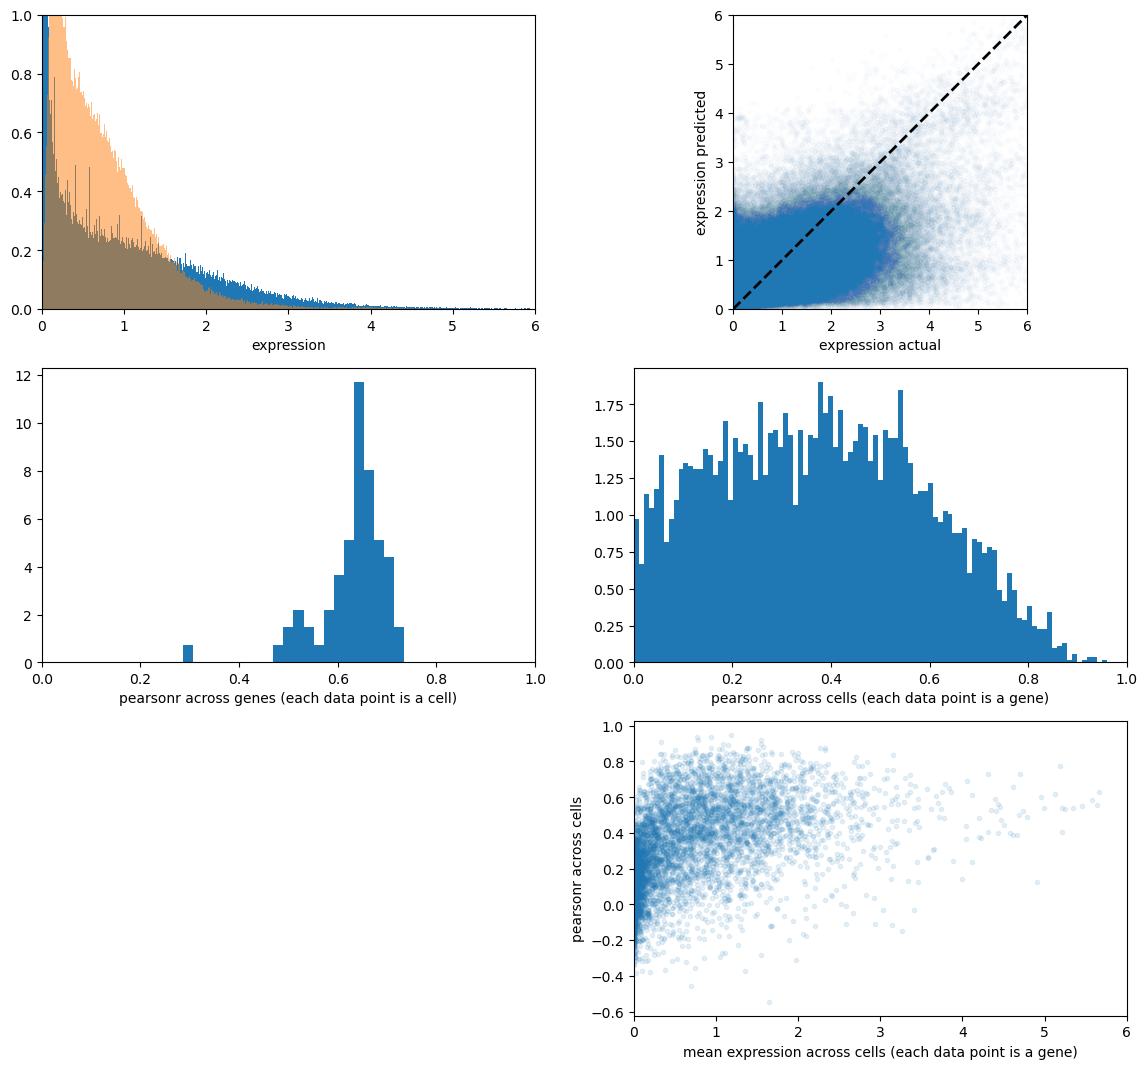

In [5]:
plot_expression_and_correlation(adata_test, results)

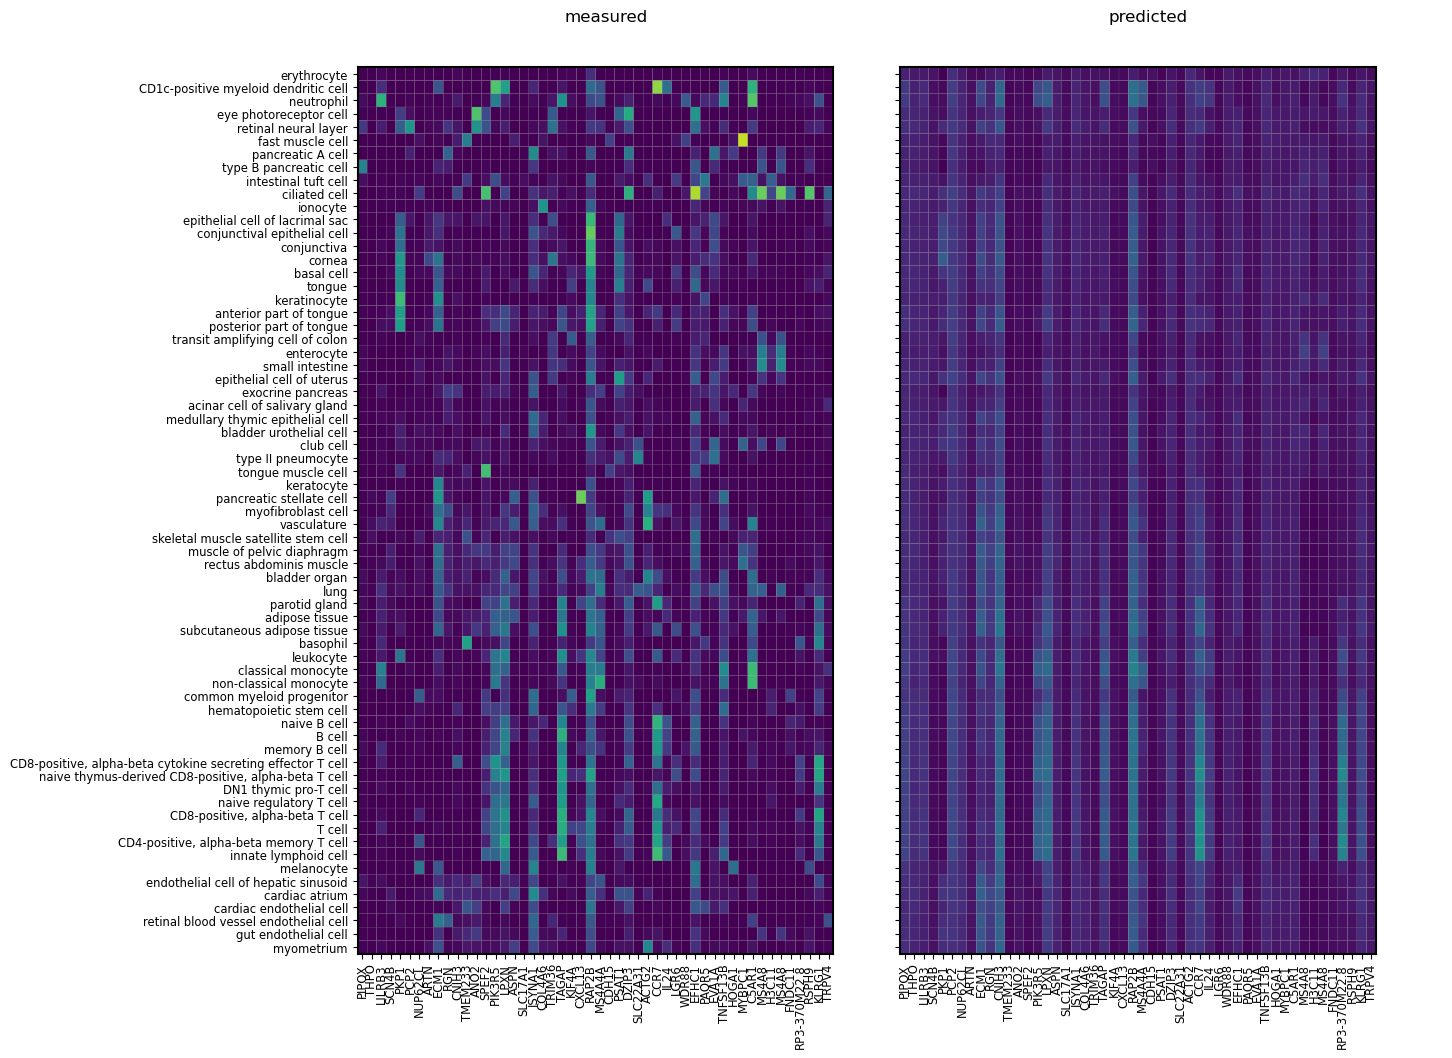

In [6]:
marker_genes = adata_test.var[adata_test.var['highly_variable']]['feature_name'].values
np.random.seed(42)
marker_genes = np.random.choice(marker_genes, 50)

plot_marker_gene_heatmap(adata_test, marker_genes)

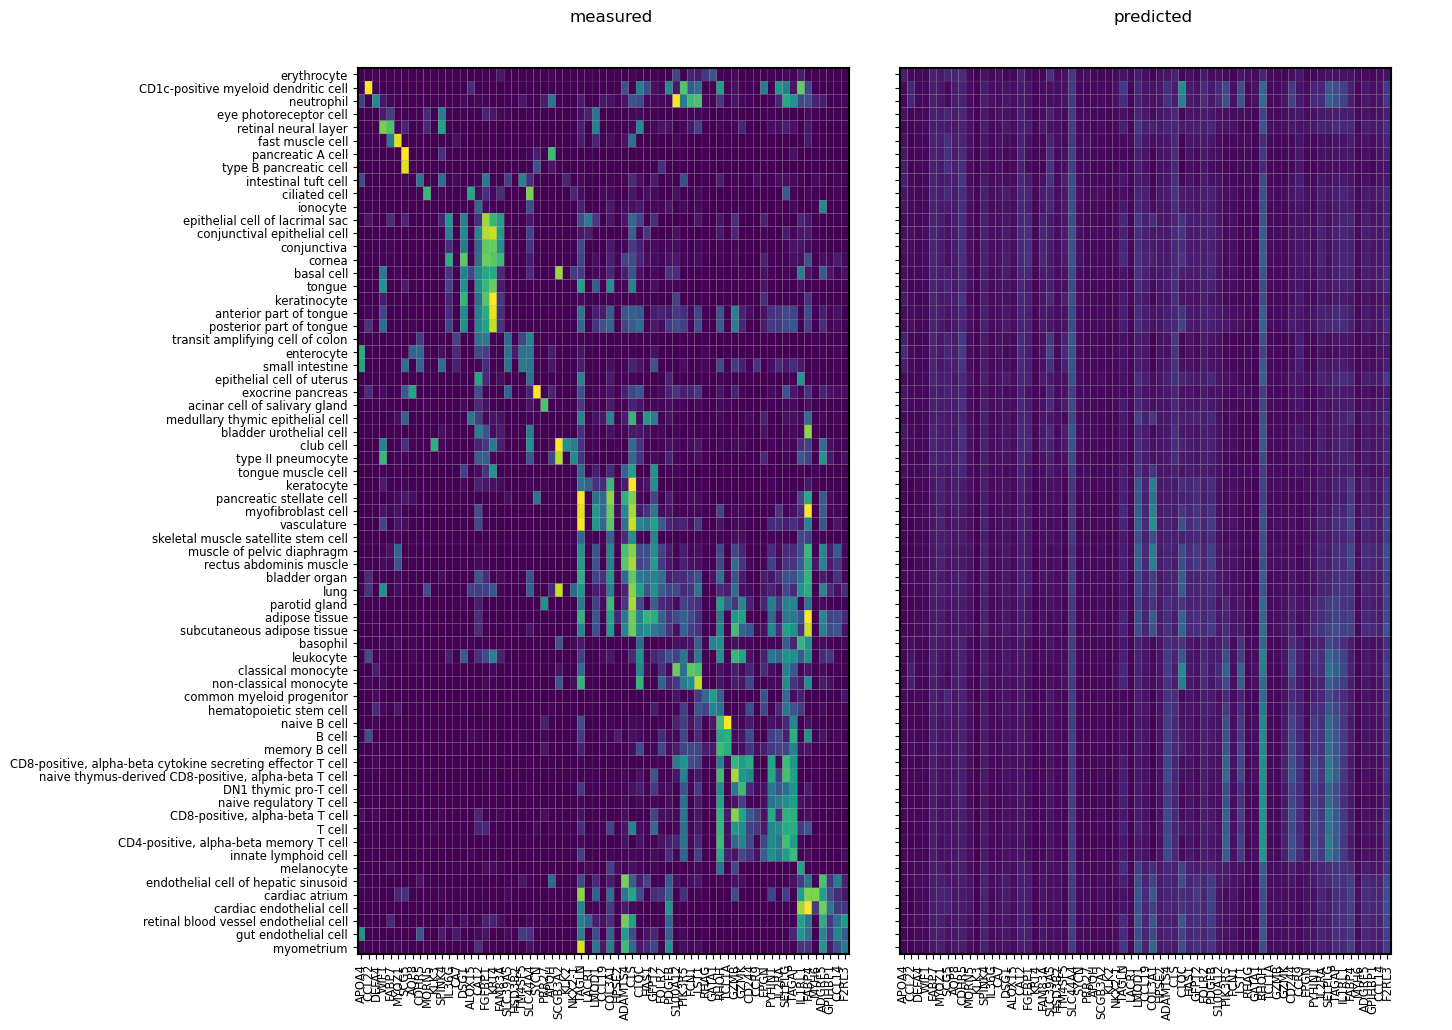

In [7]:
marker_genes_dict = adata_test.obs.set_index('label').to_dict()['marker_feature_name']
plot_marker_gene_heatmap(adata_test, marker_genes_dict)